In [1]:
import os
import math
import random

from typing import List, Tuple, Callable, Optional
from tqdm import tqdm

import pandas as pd
import numpy as np
import cv2
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn_functions import train_predict

%matplotlib inline

In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

## Reproducibility

In [2]:
RS = 42
DEVICE = 'cuda'

In [3]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    

seed_everything(RS)

## Read data

In [4]:
df = pd.read_csv('data/processed_df.csv')
df

,oroginal_path,label,basename,violla_default_pathes,violla_mn5_sf3_pathes,violla_mn1_sfdef_pathes,hog_pathes
0,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,104.jpg,/ssd_data/celebrity_data/violla/default/Angeli...,NaN,/ssd_data/celebrity_data/violla/mn1_sfdef/Ange...,NaN
1,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,724.jpg,NaN,NaN,NaN,NaN
2,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,219.jpg,NaN,NaN,NaN,NaN
3,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,541.jpg,/ssd_data/celebrity_data/violla/default/Angeli...,NaN,/ssd_data/celebrity_data/violla/mn1_sfdef/Ange...,/ssd_data/celebrity_data/hog/Angelina Jolie/54...
4,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,107.jpg,/ssd_data/celebrity_data/violla/default/Angeli...,NaN,/ssd_data/celebrity_data/violla/mn1_sfdef/Ange...,/ssd_data/celebrity_data/hog/Angelina Jolie/10...
...,...,...,...,...,...,...,...
12155,/ssd_data/cifar10/train/5672.png,no_face,5672.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/5672.png
12156,/ssd_data/cifar10/train/48106.png,no_face,48106.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/48106.png
12157,/ssd_data/cifar10/train/40719.png,no_face,40719.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/40719.png
12158,/ssd_data/cifar10/train/32756.png,no_face,32756.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/32756.png


In [5]:
LABEL2ID = {l:i for i,l in enumerate(df.label.unique())}
ID2LABEL = {v:k for k,v in LABEL2ID.items()}
LABEL2ID

{'Angelina Jolie': 0,
 'Adam Sandler': 1,
 'Alan Arkin': 2,
 'Angela Bassett': 3,
 'Alex Pettyfer': 4,
 'Al Pacino': 5,
 'Andy Samberg': 6,
 'Alan Rickman': 7,
 'Anna Friel': 8,
 'Anna Paquin': 9,
 'Andrew Luck': 10,
 'rand_celeb': 11,
 'no_face': 12}

Here we have multiclass task, so we will define each label as separate class

In [6]:
df['label_id'] = df['label'].map(LABEL2ID)
df

,oroginal_path,label,basename,violla_default_pathes,violla_mn5_sf3_pathes,violla_mn1_sfdef_pathes,hog_pathes,label_id
0,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,104.jpg,/ssd_data/celebrity_data/violla/default/Angeli...,NaN,/ssd_data/celebrity_data/violla/mn1_sfdef/Ange...,NaN,0
1,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,724.jpg,NaN,NaN,NaN,NaN,0
2,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,219.jpg,NaN,NaN,NaN,NaN,0
3,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,541.jpg,/ssd_data/celebrity_data/violla/default/Angeli...,NaN,/ssd_data/celebrity_data/violla/mn1_sfdef/Ange...,/ssd_data/celebrity_data/hog/Angelina Jolie/54...,0
4,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,107.jpg,/ssd_data/celebrity_data/violla/default/Angeli...,NaN,/ssd_data/celebrity_data/violla/mn1_sfdef/Ange...,/ssd_data/celebrity_data/hog/Angelina Jolie/10...,0
...,...,...,...,...,...,...,...,...
12155,/ssd_data/cifar10/train/5672.png,no_face,5672.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/5672.png,12
12156,/ssd_data/cifar10/train/48106.png,no_face,48106.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/48106.png,12
12157,/ssd_data/cifar10/train/40719.png,no_face,40719.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/40719.png,12
12158,/ssd_data/cifar10/train/32756.png,no_face,32756.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/32756.png,12


Now we will prepare prediction columns for each algorithm and put `no_face` label if there is a face but it was not found

In [7]:
PREPROCESS_COLS = ['violla_default_pathes', 'violla_mn5_sf3_pathes', 'violla_mn1_sfdef_pathes', 'hog_pathes']
for col in PREPROCESS_COLS:
    pred_col = col[:-len('_pathes')] + '_pred'
    df[pred_col] = None
    df.loc[df[col].isna() & (df['label_id'] != 12), pred_col] = 12

In [8]:
df

,oroginal_path,label,basename,violla_default_pathes,violla_mn5_sf3_pathes,violla_mn1_sfdef_pathes,hog_pathes,label_id,violla_default_pred,violla_mn5_sf3_pred,violla_mn1_sfdef_pred,hog_pred
0,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,104.jpg,/ssd_data/celebrity_data/violla/default/Angeli...,NaN,/ssd_data/celebrity_data/violla/mn1_sfdef/Ange...,NaN,0,None,12,None,12
1,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,724.jpg,NaN,NaN,NaN,NaN,0,12,12,12,12
2,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,219.jpg,NaN,NaN,NaN,NaN,0,12,12,12,12
3,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,541.jpg,/ssd_data/celebrity_data/violla/default/Angeli...,NaN,/ssd_data/celebrity_data/violla/mn1_sfdef/Ange...,/ssd_data/celebrity_data/hog/Angelina Jolie/54...,0,None,12,None,None
4,/ssd_data/celebrity_data/dir_001/Angelina Joli...,Angelina Jolie,107.jpg,/ssd_data/celebrity_data/violla/default/Angeli...,NaN,/ssd_data/celebrity_data/violla/mn1_sfdef/Ange...,/ssd_data/celebrity_data/hog/Angelina Jolie/10...,0,None,12,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
12155,/ssd_data/cifar10/train/5672.png,no_face,5672.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/5672.png,12,None,None,None,None
12156,/ssd_data/cifar10/train/48106.png,no_face,48106.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/48106.png,12,None,None,None,None
12157,/ssd_data/cifar10/train/40719.png,no_face,40719.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/40719.png,12,None,None,None,None
12158,/ssd_data/cifar10/train/32756.png,no_face,32756.png,/ssd_data/celebrity_data/violla/default/cifar/...,/ssd_data/celebrity_data/violla/mn5_sf3/cifar/...,/ssd_data/celebrity_data/violla/mn1_sfdef/cifa...,/ssd_data/celebrity_data/hog/cifar/32756.png,12,None,None,None,None


## Train/Test split

In [9]:
def train_test_split(
    df_p: pd.DataFrame,
    split_col: str
):
    cv_policy = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=RS)
    train_idx, test_idx = list(cv_policy.split(df_p, df_p[split_col]))[0]
    
    return (
        df_p.iloc[train_idx].reset_index(drop=True), 
        df_p.iloc[test_idx].reset_index(drop=True)
    )

In [10]:
train_df, test_df = train_test_split(
    df_p=df,
    split_col='label_id'
)

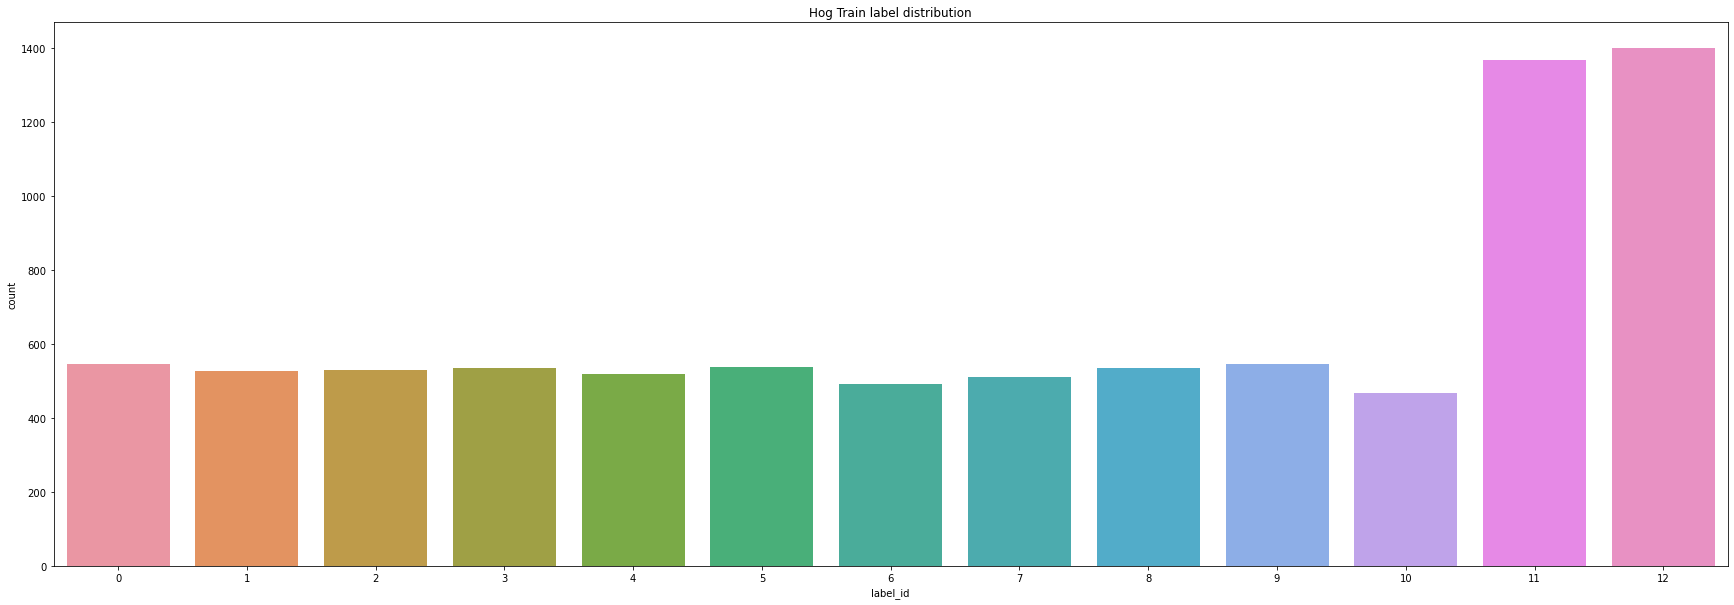

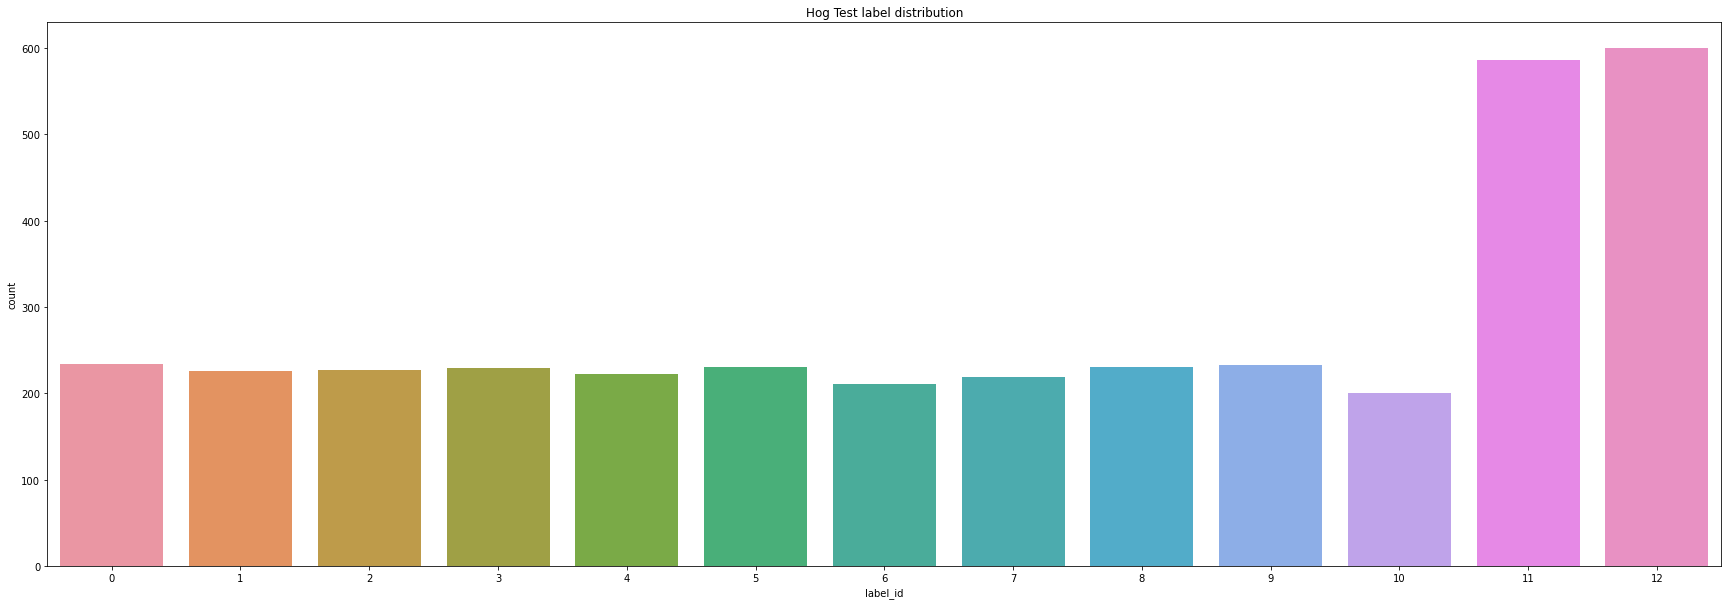

In [11]:
plt.figure(figsize=(30,10))
plt.title("Hog Train label distribution")
sns.countplot(train_df.label_id)
plt.show()

plt.figure(figsize=(30,10))
plt.title("Hog Test label distribution")
sns.countplot(test_df.label_id)
plt.show()

In [12]:
result_df = pd.DataFrame(
    columns=[
        'exp_name', 
        'overall_accuracy_val', 'joli_accuracy_val',
        'overall_accuracy_train', 'joli_accuracy_train',
    ]
)

In [13]:
#!rm logdirs -rf

## Hog dataset

### Train and Infernce

In [14]:
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=1024, random_state=RS)),
    ('svc', SVC(random_state=RS))
])

In [15]:
hog_train_pred, hog_test_pred, _ = train_predict(
    sklearn_alg=pipe,
    train_df=train_df[~train_df.hog_pathes.isna()].reset_index(drop=True),
    val_df=test_df[~test_df.hog_pathes.isna()].reset_index(drop=True),
    path_col='hog_pathes',
    target_col='label_id'
)

  5%|▍         | 371/7834 [00:00<00:02, 3705.20it/s]

Train processing


100%|██████████| 7834/7834 [00:01<00:00, 4001.05it/s]


Fit model
Train predciting


 12%|█▏        | 404/3363 [00:00<00:00, 4033.90it/s]

Test processing


100%|██████████| 3363/3363 [00:00<00:00, 4082.67it/s]


Test predciting
Ready!!!


In [16]:
test_df.loc[~test_df.hog_pathes.isna(), 'hog_pred'] = hog_test_pred
test_df['hog_pred'] = test_df['hog_pred'].astype(int)

train_df.loc[~train_df.hog_pathes.isna(), 'hog_pred'] = hog_train_pred
train_df['hog_pred'] = train_df['hog_pred'].astype(int)

In [17]:
result_df = result_df.append({
    "exp_name":'hog_svm', 
    "overall_accuracy_val":accuracy_score(test_df.label_id, test_df.hog_pred),
    "joli_accuracy_val":accuracy_score(test_df[test_df.label_id == 0].label_id, test_df[test_df.label_id == 0].hog_pred),
    "overall_accuracy_train":accuracy_score(train_df.label_id, train_df.hog_pred),
    "joli_accuracy_train":accuracy_score(train_df[train_df.label_id == 0].label_id, train_df[train_df.label_id == 0].hog_pred)
}, ignore_index=True)

result_df

,exp_name,overall_accuracy_val,joli_accuracy_val,overall_accuracy_train,joli_accuracy_train
0,hog_svm,0.518092,0.380342,0.724624,0.565934


## Violla_default dataset

### Train and Infernce

In [18]:
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=1024, random_state=RS)),
    ('svc', SVC(random_state=RS))
])

In [19]:
violla_default_train_pred, violla_default_test_pred, _ = train_predict(
    sklearn_alg=pipe,
    train_df=train_df[~train_df.violla_default_pathes.isna()].reset_index(drop=True),
    val_df=test_df[~test_df.violla_default_pathes.isna()].reset_index(drop=True),
    path_col='violla_default_pathes',
    target_col='label_id'
)

  6%|▌         | 401/7034 [00:00<00:01, 4007.59it/s]

Train processing


100%|██████████| 7034/7034 [00:01<00:00, 4005.53it/s]


Fit model
Train predciting


 13%|█▎        | 401/3032 [00:00<00:00, 4007.29it/s]

Test processing


100%|██████████| 3032/3032 [00:00<00:00, 4036.31it/s]


Test predciting
Ready!!!


In [20]:
test_df.loc[~test_df.violla_default_pathes.isna(), 'violla_default_pred'] = violla_default_test_pred
test_df['violla_default_pred'] = test_df['violla_default_pred'].astype(int)

train_df.loc[~train_df.violla_default_pathes.isna(), 'violla_default_pred'] = violla_default_train_pred
train_df['violla_default_pred'] = train_df['violla_default_pred'].astype(int)

In [21]:
result_df = result_df.append({
    "exp_name":'violla_default_baseline', 
    "overall_accuracy_val":accuracy_score(test_df.label_id, test_df.violla_default_pred),
    "joli_accuracy_val":accuracy_score(test_df[test_df.label_id == 0].label_id, test_df[test_df.label_id == 0].violla_default_pred),
    "overall_accuracy_train":accuracy_score(train_df.label_id, train_df.violla_default_pred),
    "joli_accuracy_train":accuracy_score(train_df[train_df.label_id == 0].label_id, train_df[train_df.label_id == 0].violla_default_pred)
}, ignore_index=True)

result_df

,exp_name,overall_accuracy_val,joli_accuracy_val,overall_accuracy_train,joli_accuracy_train
0,hog_svm,0.518092,0.380342,0.724624,0.565934
1,violla_default_baseline,0.521656,0.329060,0.679394,0.496337


## Violla_mn1_sfdef_pathes dataset

### Train and Infernce

In [22]:
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=1024, random_state=RS)),
    ('svc', SVC(random_state=RS))
])

In [23]:
violla_mn1_sfdef_train_pred, violla_mn1_sfdef_test_pred, _ = train_predict(
    sklearn_alg=pipe,
    train_df=train_df[~train_df.violla_mn1_sfdef_pathes.isna()].reset_index(drop=True),
    val_df=test_df[~test_df.violla_mn1_sfdef_pathes.isna()].reset_index(drop=True),
    path_col='violla_mn1_sfdef_pathes',
    target_col='label_id'
)

  5%|▌         | 410/7768 [00:00<00:01, 4094.20it/s]

Train processing


100%|██████████| 7768/7768 [00:01<00:00, 4051.51it/s]


Fit model
Train predciting


 24%|██▍       | 819/3345 [00:00<00:00, 4075.64it/s]

Test processing


100%|██████████| 3345/3345 [00:00<00:00, 4101.41it/s]


Test predciting
Ready!!!


In [24]:
test_df.loc[~test_df.violla_mn1_sfdef_pathes.isna(), 'violla_mn1_sfdef_pred'] = violla_mn1_sfdef_test_pred
test_df['violla_mn1_sfdef_pred'] = test_df['violla_mn1_sfdef_pred'].astype(int)

train_df.loc[~train_df.violla_mn1_sfdef_pathes.isna(), 'violla_mn1_sfdef_pred'] = violla_mn1_sfdef_train_pred
train_df['violla_mn1_sfdef_pred'] = train_df['violla_mn1_sfdef_pred'].astype(int)

In [25]:
result_df = result_df.append({
    "exp_name":'violla_mn1_sfdef_baseline', 
    "overall_accuracy_val":accuracy_score(test_df.label_id, test_df.violla_mn1_sfdef_pred),
    "joli_accuracy_val":accuracy_score(test_df[test_df.label_id == 0].label_id, test_df[test_df.label_id == 0].violla_mn1_sfdef_pred),
    "overall_accuracy_train":accuracy_score(train_df.label_id, train_df.violla_mn1_sfdef_pred),
    "joli_accuracy_train":accuracy_score(train_df[train_df.label_id == 0].label_id, train_df[train_df.label_id == 0].violla_mn1_sfdef_pred)
}, ignore_index=True)

result_df

,exp_name,overall_accuracy_val,joli_accuracy_val,overall_accuracy_train,joli_accuracy_train
0,hog_svm,0.518092,0.380342,0.724624,0.565934
1,violla_default_baseline,0.521656,0.329060,0.679394,0.496337
2,violla_mn1_sfdef_baseline,0.534539,0.316239,0.710409,0.512821


## Sort and Save

In [26]:
result_df.sort_values('joli_accuracy_val')

,exp_name,overall_accuracy_val,joli_accuracy_val,overall_accuracy_train,joli_accuracy_train
2,violla_mn1_sfdef_baseline,0.534539,0.316239,0.710409,0.512821
1,violla_default_baseline,0.521656,0.329060,0.679394,0.496337
0,hog_svm,0.518092,0.380342,0.724624,0.565934


In [28]:
result_df.to_csv('data/svm_result_df.csv', index=False)